# Анализ данных сайта Stackoverflow

## Введение

Вам нужно написать несколько SQL-запросов в Jupyter Notebook. 

Необходимые данные находятся в таблицах схемы `stackoverflow`. Не забудьте подключиться к базе с помощью SQLAlchemy. 

Некоторые задания включают дополнительные вопросы — не пропустите их. На часть вопросов можно ответить текстом, а для некоторых понадобится визуализация. Помните, что результат запроса можно выгрузить в датафрейм. 

Чтобы ожидаемый результат было легче представить, мы добавили к каждому заданию небольшой фрагмент итоговой таблицы. В запросах вы можете использовать любые подходящие названия полей.

### Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns

FIGSIZE = (12, 6)

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': '**********', # пароль
    'host': '*******************.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT DISTINCT DATE_TRUNC('month', creation_date) AS month,
    SUM(views_count) OVER(PARTITION BY DATE_TRUNC('month', creation_date)) AS month_views
FROM stackoverflow.posts
WHERE (creation_date::date >= '2008-01-01') AND (creation_date::date <= '2008-12-31')
ORDER BY month;
'''

# выполните запрос
views_monthly = pd.read_sql_query(query, con=engine) 
views_monthly

,month,month_views
0,2008-07-01,669895
1,2008-08-01,131367083
2,2008-09-01,452928568
3,2008-10-01,365400138
4,2008-11-01,221759651
5,2008-12-01,197792841


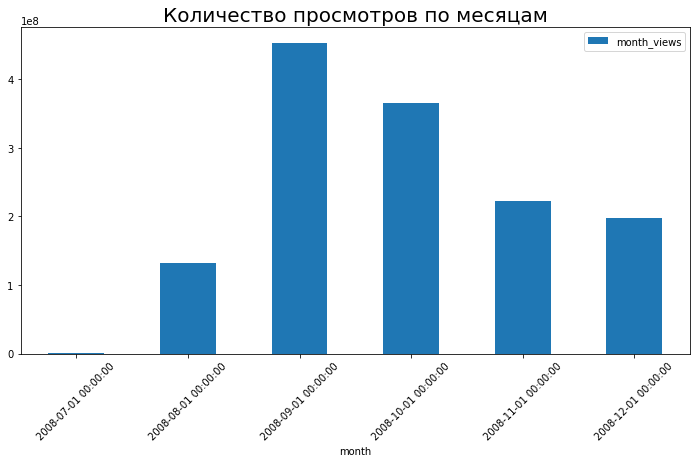

In [7]:
# визуализация результатов запроса
chart = views_monthly.plot(x='month', y='month_views', kind='bar', rot=45, figsize=FIGSIZE)
chart.set_title('Количество просмотров по месяцам', fontsize=20);

Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

**Вывод**

Видим, что в таблице наблюдается различие данных о просмотрах по месяцам. 

Первое полугодие 2008 года вообще не представлено в таблице. Это связано с тем, что сайт Stackoverflow  появился в 2008 году. Раз нет данных о первом полугодии, то логично предположить, что сайт заработал в июле 2008 года. 

В первый месяц работы сайта количество просмотров самое маленькое. Причин тут может быть две:

1. Количество пользователей Интернета, которые знали о появлении Stackoverflow, было невелико.

2. В июле сайт заработал не с первого числа, а ближе к середине месяца.

Дальше количество просмотров растет и достигает максимума в третьем месяце работы сайта. Скачок количества просмотров можно объяснить повышенным интересом аудитории к новому сайту. Далее происходит спад просмотров, что говорит о том, что пользователи стали привыкать к имеющемуся функционалу и посещать сайт только при возникновении необходимости. 


In [8]:
# посмотрим распределение просмотров по дням июля 2008 года
query = '''
SELECT DISTINCT DATE_TRUNC('day', creation_date) AS day,
    SUM(views_count) OVER(PARTITION BY DATE_TRUNC('day', creation_date)) AS day_views
FROM stackoverflow.posts
WHERE (creation_date::date >= '2008-07-01') AND (creation_date::date <= '2008-07-31')
ORDER BY day;
'''

# выполните запрос
views_07_dayly = pd.read_sql_query(query, con=engine) 
views_07_dayly

,day,day_views
0,2008-07-31,669895


Видим, что предположение о том, что в июле сайт работал не полный месяц подтвердилось. Более того, видим, что он работал в этом месяце всего один день.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [9]:
# напишите запрос
query = '''
WITH post_user_stat AS
    (SELECT pt.type,
        p.id AS post_id,
        p.user_id,
        p.creation_date AS post_date,
        u.display_name,
        u.creation_date AS user_reg,
        DATE_TRUNC('day', p.creation_date) - DATE_TRUNC('day', u.creation_date) AS diff
    FROM stackoverflow.post_types AS pt
    JOIN stackoverflow.posts AS p ON p.post_type_id = pt.id
    JOIN stackoverflow.users AS u ON p.user_id = u.id
    WHERE (pt.type = 'Answer'))
SELECT display_name,
    COUNT(DISTINCT user_id) as num_of_ids
FROM post_user_stat
WHERE diff <= '1 month'
GROUP BY display_name
HAVING COUNT(post_id) > 100
ORDER BY display_name;
'''

# выполните запрос
user_asw_id = pd.read_sql_query(query, con=engine)
user_asw_id

,display_name,num_of_ids
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Какие аномалии наблюдаются в данных? О чём они говорят?

**Вывод**

По результатам запроса видно, что в данных есть 17 отображаемых имен пользователей, на которые приходится более одного уникального id пользователя. Это связано с тем, что правила Stackoverflow позволяют разным пользователям иметь одинаковые отображаемые имена.

Видим, что самые эти 17 имен – это имена собственные без уточнения фамилии или какого-то другого признака, который сделал бы их уникальными, как в случае с остальными именами самых активных пользователей.

Кроме того, при построении запроса выяснилось, что в базе есть пользователи, у которых разница между датой публикации и датой регистрации отрицательная, то есть пост опубликован до регистрации. Это может быть результатом сбоя работы сайта или результатом того, что после регистрации пользователь корректировал данные о часовом поясе своего пребывания.


# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [10]:
# напишите запрос
query = '''
WITH users_list AS
    (SELECT DISTINCT p.user_id
    FROM stackoverflow.posts AS p
    JOIN stackoverflow.users AS u ON p.user_id = u.id
    WHERE ((p.creation_date::date >= '2008-12-01') AND (p.creation_date::date <= '2008-12-31'))
    AND ((u.creation_date::date >= '2008-09-01') AND (u.creation_date::date <= '2008-09-30')))
SELECT DISTINCT DATE_TRUNC('month', p.creation_date) AS month,
    COUNT(p.id)
FROM users_list AS ul
JOIN stackoverflow.posts AS p ON ul.user_id = p.user_id
GROUP BY DATE_TRUNC('month', p.creation_date)
ORDER BY month DESC;
'''

# выполните запрос
by_month_2008= pd.read_sql_query(query, con=engine)
by_month_2008

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


In [11]:
# количество августовских постов пользователей, зарегистрированных в сенбябре
query = '''
WITH users_list AS
    (SELECT DISTINCT p.user_id
    FROM stackoverflow.posts AS p
    JOIN stackoverflow.users AS u ON p.user_id = u.id
    WHERE ((p.creation_date::date >= '2008-12-01') AND (p.creation_date::date <= '2008-12-31'))
    AND ((u.creation_date::date >= '2008-09-01') AND (u.creation_date::date <= '2008-09-30')))
SELECT DISTINCT DATE_TRUNC('day', p.creation_date) AS month,
    COUNT(p.id)
FROM users_list AS ul
JOIN stackoverflow.posts AS p ON ul.user_id = p.user_id
WHERE (p.creation_date::date >= '2008-08-01') AND (p.creation_date::date <= '2008-08-31')
GROUP BY DATE_TRUNC('day', p.creation_date)
ORDER BY month DESC;
'''

# выполните запрос
august_2008= pd.read_sql_query(query, con=engine)
august_2008

,month,count
0,2008-08-31,1
1,2008-08-30,3
2,2008-08-29,5
3,2008-08-28,1
4,2008-08-27,2
5,2008-08-25,3
6,2008-08-24,1
7,2008-08-22,1
8,2008-08-21,1
9,2008-08-20,1


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

**Вывод**

В результатах выдачи нашего запроса аномальным значением является 32 поста, опубликованных в августе 2008 года, потому что мы отбирали пользователей, которые были зарегистрированы только в сентябре.

Причиной могли быть сбои в работе сайта, хакерская атака или обновление ПО, обеспечивающего работу Stackoverflow или его хостинга.


# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [12]:
# напишите запрос
query = '''
SELECT user_id,
    creation_date,
    views_count,
    SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id;
'''

# выполните запрос
posts = pd.read_sql_query(query, con=engine)
posts

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [13]:
# напишите запрос
query = '''
WITH aug_user_day_count AS
    (WITH aug_stat AS
        (SELECT DISTINCT user_id,
            COUNT(id) AS num_of_posts
        FROM stackoverflow.posts
        WHERE (creation_date::date >= '2008-08-01') AND (creation_date::date <= '2008-08-31')
        GROUP BY user_id
        HAVING COUNT(id) > 120)
    SELECT p.user_id,
         DATE_TRUNC('day', p.creation_date),
         COUNT(p.id) AS num_of_posts
    FROM stackoverflow.posts AS p
    JOIN aug_stat AS a ON p.user_id = a.user_id
    WHERE (p.creation_date::date >= '2008-08-01') AND (p.creation_date::date <= '2008-08-31')
    GROUP BY p.user_id, DATE_TRUNC('day', p.creation_date)
    ORDER BY p.user_id)
SELECT user_id,
    SUM(num_of_posts) / COUNT(date_trunc) AS avg_daily
FROM aug_user_day_count
GROUP BY user_id
ORDER BY avg_daily;
'''

# выполните запрос
posts_in_august = pd.read_sql_query(query, con=engine)
posts_in_august

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [14]:
# напишите запрос
query = '''
WITH week_stat AS
    (SELECT user_id,
        COUNT(DISTINCT DATE_TRUNC('day', creation_date))
    FROM stackoverflow.posts
    WHERE (creation_date::date >= '2008-12-01') AND (creation_date::date <= '2008-12-07')
    GROUP BY user_id)
SELECT ROUND(AVG(count))
FROM week_stat;
'''

# выполните запрос
pd.read_sql_query(query, con=engine)

,round
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

**Вывод**

В первую неделю декабря 2008 года пользователи обращались к Stackoverflow в среднем 2 дня в неделю.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [15]:
query = '''
SELECT user_id,
    creation_date,
    TO_CHAR(LAG(creation_date, 2, NULL) OVER (PARTITION BY user_id ORDER BY creation_date), 'Month')
FROM stackoverflow.posts;
'''

# выполните запрос
pd.read_sql_query(query, con=engine)

,user_id,creation_date,to_char
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [16]:
# выделим подзапрос для подсчета количества пользователей каждой когорты
query = '''
WITH first_posts AS
    (SELECT DISTINCT user_id,
        MIN(DATE_TRUNC('month', creation_date)) OVER (PARTITION BY user_id) AS first_post_date
    FROM stackoverflow.posts) 
SELECT user_id,
    first_post_date,
    COUNT(*) OVER (PARTITION BY first_post_date) AS cohort_users_cnt
FROM first_posts;
'''

# выполните запрос
profile = pd.read_sql_query(query, con = engine)
profile.head()

,user_id,first_post_date,cohort_users_cnt
0,9,2008-07-01,3
1,1,2008-07-01,3
2,8,2008-07-01,3
3,3234,2008-08-01,2151
4,3236,2008-08-01,2151


In [17]:
# выделим подзапрос со статистикой постов пользователей
query = '''
SELECT user_id,
    creation_date::date AS post_date
FROM stackoverflow.posts;
'''

# выполните запрос
sessions = pd.read_sql_query(query, con = engine)
sessions.head()

,user_id,post_date
0,8,2008-07-31
1,9,2008-07-31
2,9,2008-07-31
3,1,2008-07-31
4,1,2008-07-31


In [18]:
# вычисляем Retention Rate
query = '''
WITH profile AS
    (WITH first_posts AS
        (SELECT DISTINCT user_id,
            MIN(DATE_TRUNC('month', creation_date)) OVER (PARTITION BY user_id) AS first_post_date
        FROM stackoverflow.posts) 
    SELECT user_id,
        first_post_date,
        COUNT(*) OVER (PARTITION BY first_post_date) AS cohort_users_cnt
    FROM first_posts),
sessions AS 
    (SELECT user_id,
        DATE_TRUNC('month', creation_date) AS post_date
    FROM stackoverflow.posts
    GROUP BY 1,
             2)
SELECT p.first_post_date AS cohort_dt,
       post_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1,
         2,
         4;
'''

# выполните запрос
retention_rate_df = pd.read_sql_query(query, con = engine)
retention_rate_df.head(10)

,cohort_dt,post_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

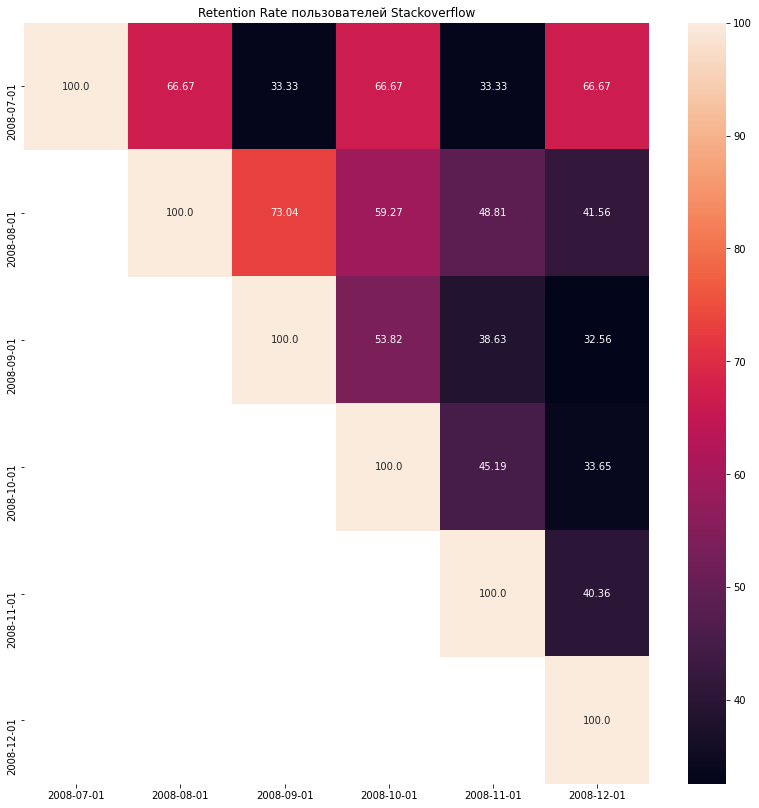

In [19]:
# постройте тепловую карту Retention Rate

# создаём сводную таблицу с результатами
retention = retention_rate_df.pivot('cohort_dt', 'post_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(14, 14)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Retention Rate пользователей Stackoverflow') # название графика
plt.show() 

**Вывод**

**Аномалии или другие необычные явления и сформулируйте гипотезы**

На тепловой карте видно, что в целом Retention Rate пользователей Stackoverflow снижается по месяцам. Исключение составляет первая когорта пользователей, где Retention Rate попеременно принимает значения 33,33 и 66,67. Причиной такой аномалии скорее всего является малая численность первой когорты – всего 3 человека.

Кроме того, процент возврата во втором месяце самый высокий в первой когорте и последовательно снижается в каждой следующей.


# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [20]:
# напишите запрос
query = '''
WITH monthly_stat AS
    (SELECT DISTINCT EXTRACT(MONTH FROM creation_date) AS month,
        COUNT(id) OVER (PARTITION BY EXTRACT(MONTH FROM creation_date)) AS num_of_posts
    FROM stackoverflow.posts
    WHERE (creation_date::date >= '2008-09-01') AND (creation_date::date <= '2008-12-31')
    )
SELECT month,
    num_of_posts,
    ROUND((num_of_posts - (LAG(num_of_posts, 1, NULL) OVER ())) / CAST ( LAG(num_of_posts, 1, NULL) OVER () AS numeric) * 100, 2) AS percentage
FROM monthly_stat;
'''

# выполните запрос
posts_monthly = pd.read_sql_query(query, con = engine)
posts_monthly

,month,num_of_posts,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

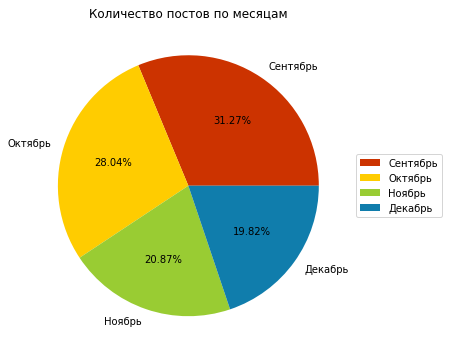

In [21]:
# постройте круговую диаграмму с количеством постов по месяцам
posts_monthly.plot(
    kind='pie', 
    labels = ['Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь'],
    y='num_of_posts', 
    figsize = FIGSIZE,
    colors = ["#cc3300", "#ffcc00", "#99cc33", "#107dac"],
    title='Количество постов по месяцам',
    autopct='%.2f%%'
)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel("");

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [22]:
# напишите запрос
query = '''
WITH user_info AS
    (SELECT user_id
    FROM stackoverflow.posts
    GROUP BY user_id
    ORDER BY COUNT (id) DESC
    LIMIT 1)
SELECT DISTINCT EXTRACT(WEEK FROM creation_date),
    MAX(creation_date) OVER (PARTITION BY EXTRACT(WEEK FROM creation_date))
FROM stackoverflow.posts AS p
JOIN user_info AS ui ON p.user_id = ui.user_id
WHERE (creation_date::date >= '2008-10-01') AND (creation_date::date <= '2008-10-31')
'''

# выполните запрос
pd.read_sql_query(query, con = engine)

,date_part,max
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


# Вывод

Был **проведен анализ данных пользователей сайта Stackoverflow** за первые полгода его работы.

В данных присутствуют **аномалии**: 

- у некоторых пользователей первый **пост опубликован до их регистрации на сайте**

- правила Stackoverflow позволяют **разным пользователям иметь одинаковые отображаемые имена**, это требует аккуратности при подсчете пользовательской статистики.

**Анализ поведения пользователей**.

**Динамика просмотров** в первый год работы сайта. В первый месяц (июль) работы сайта количество просмотров самое маленькое. Дальше количество просмотров растет и достигает максимума в третьем месяце работы сайта (сентябрь). Затем происходит спад просмотров, что говорит о том, что пользователи стали привыкать к имеющемуся функционалу и посещать сайт только при возникновении необходимости.

**Количество публикаций** с сентября по декабрь 2008 года постепенно уменьшается.

**Возврат пользователей на сайт**. Для подсчета Retention Rate пользователей разбили на когорты по месяцу первой публикации. Retention Rate снижается по месяцам в каждой когорте. Кроме того, процент возврата во втором месяце самый высокий в первой когорте и последовательно снижается в каждой следующей.
